In [1]:
import sys
import glob
import os
import pandas as pd
import ee
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from datetime import datetime, timedelta

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [2]:
# EE functions are in the rsfuncs module. Loacal functions are here: 

In [76]:
def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df

def get_ims_by_date(ims_list, var):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        print(i)
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon(latlon, var))
        date =  latlon.get('system:time_start')
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)

    return imlist, imdates

def array_from_latlon(latlon_obj, var):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get(var)).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def make_np_array(data, lats, lons):
    # get data from df as arrays
    lons = np.array(lons)
    lats = np.array(lats)
    data = np.array(data) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-1, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

In [4]:
site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR"])]

In [79]:
data = rs.load_data()

In [6]:
data_dir = "../data"

In [184]:
# For each site id, find the sm file with the data (in data dir), 
# calculate psi as psi = A * SM ^b (krishna's paper )
# query the (1) landcover, (2) Sentinel backscatter (Prism P), MODIS / Landsat LAI for the whole timeseries 
   
for idx, row in sites[:1].iterrows():
    
    print("Processings site no {}".format(row.id))
    
    # Make geom to submit to EE 
    x,y = row.geometry.buffer(0.0001).envelope.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
        
    # start and end date
    startdate = sm_dat.index[0]
    enddate = sm_dat.index[-1]
    
    date = startdate.strftime("%Y-%m-%d")
    
    # Select the nlcd dataset
    dataset =  data['nlcd']
    ic = dataset[0]
    var = dataset[1]
    res = dataset[3]
    
    # find the nearest nlcd dataset 
    col = ic.filterDate(ee.Date(date).advance(-1, 'years'), ee.Date(date).advance(2, 'years')).first()
    t = col.reduceRegion(ee.Reducer.mean(), area, res).get(var)
    meta = col.getInfo()
    lc_class = t.getInfo()
    
    # Get the landcover type
    lcidx = meta['properties']['landcover_class_values'].index(lc_class)
    lctype = meta['properties']['landcover_class_names'][lcidx]
    print(lctype)
    
    # Get Sentinel images and dates (ascending orbits only, VV polarization)
    print("Fetching sentinel data ")
    s1 = data['s1']
    s1ic, s1var, s1res = s1[0], s1[1], s1[3]
    
    s1_col = s1ic.filterBounds(area).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    s1_col = s1_col.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select(s1var)
    
    s1_col = s1_col.filterDate(startdate,enddate)
    t = s1_col.sort('system:time_start')
    ims = t.toList(t.size())
    
    s1dat, dates = get_ims_by_date(ims,s1var)
    
    # Calc the S1 mean backscatter in each image
    mean_sigmas = []
    std_sigmas = []

    for i in s1dat:
        mean_sigmas.append(np.mean(i))
        std_sigmas.append(np.std(i))
    
    # Convert the datestrings from S1 to pandas datetimes 
    for idx, x in enumerate(dates):
        timestamp = x.find("1SDV_")+5
        timestr = x[timestamp:timestamp+13]
        dates[idx] = pd.to_datetime(timestr, format='%Y%m%d %H:%M')
    
    # Get PRISM data for all the S1 overpass dates
    rainfall = []

#     for i,x in enumerate(dates):
#         y,m,d = dates[i].year, dates[i].month, dates[i].day
#         t = filter_date(data['prism_daily'][0], y, m, d).sum()
#         precip_total = get_2day_precip(t)
#         rainfall.append(precip_total)

    # filter out the rainy dates 

    # Get the NDVI / AGB - Landsat / MODIS over the whole timeseries, perform golay filtering 
    
    
    # Filter the SCAN data for the S1 dates, average root zone and surface over +- 3 hours 
    rzsm = []
    ssm = []
    
    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=i.hour)+timedelta(hours= - 2)
        endtime = starttime+timedelta(hours= 4)
        df = pd.DataFrame(sm_dat[starttime:endtime])
        
        rzsm.append(df[df.columns[-1]].values)
        ssm.append(df[df.columns[-3]].values)
    
    # In case there are nans or data gaps in the sm data
    rzsm = [list(filter(None, x)) for x in rzsm]
    ssm = [list(filter(None, x)) for x in ssm]
    
    # Calc the 5 hour mean for each sensor reading 
    for idx,x in enumerate(rzsm):
        rzsm[idx] = np.nanmean([np.float(i) for i in x])
    
    for idx,x in enumerate(ssm):
        ssm[idx] = np.nanmean([np.float(i) for i in x])

    # params to calculate psi 
    a = row.a
    b = row.b
    
    # RZ and Surface LWP = A * sm ^b
    psi1 = [a*(x/100)**b for x in rzsm]
    psi2 = [a*(x/100)**b for x in ssm]
    
    

Processings site no 2057
Deciduous Forest - Areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75 percent of the tree species shed foliage simultaneously in response to seasonal change.
Fetching sentinel data 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice


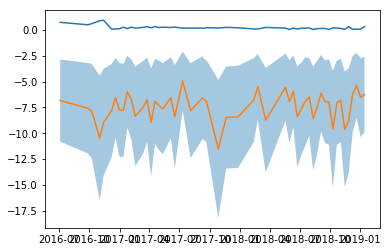

In [193]:
mean_sigmas = np.array(mean_sigmas)
plt.plot(dates,psi1)
# plt.plot(dates,psi2)
plt.plot(dates,mean_sigmas)
plt.fill_between(dates,mean_sigmas+std_sigmas, mean_sigmas - std_sigmas, alpha = 0.4)

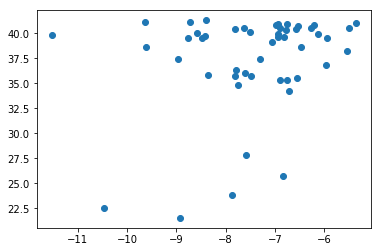

In [196]:
plt.scatter(mean_sigmas, ssm)

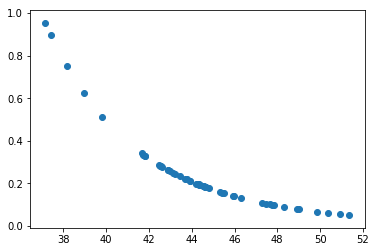

In [201]:
# plt.scatter(ssm, psi2)
plt.scatter(rzsm, psi1)

In [181]:
a

0.000129703847821

In [124]:
t2 = [np.float(x) for x in rzsm[0]]

In [125]:
np.mean(t2)

38.160000000000004

In [54]:
dates[0].find("1SDV_")

30

In [64]:
dates[0][dates[0].find("1SDV_")+5:dates[0].find("1SDV_")+13]

'20160703'

In [ ]:
lcidx = meta['properties']['landcover_class_values'].index(lctype)
lctype = meta['properties']['landcover_class_names'][lcidx]

In [ ]:
# Helpers 

In [ ]:
# EE --> Numpy functions

In [29]:
def array_from_latlon(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get("VV")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def array_from_latlon_ppt(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def make_np_array(data, lats, lons):
    # get data from df as arrays
    lons = np.array(lons)
    lats = np.array(lats)
    data = np.array(data) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def get_ims_by_date(ims_list):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        print(i)
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon(latlon))
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)

    return imlist, imdates

#     times = []
#     for i in imdates:
#         time_idx = i.find("T0")
#         ymd = i[time_idx-8:time_idx]
#         hms = i[time_idx+1:time_idx+7]
#         times.append(datetime.strptime(ymd+hms, '%Y%m%d%H%M%S'))


def get_ims_dates_ppt(ims_list):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon_ppt(latlon))
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)
    
    times = []
    for i in imdates:
        time_idx = i.find("T0")
        ymd = i[time_idx-8:time_idx]
        hms = i[time_idx+1:time_idx+7]
        times.append(datetime.strptime(ymd+hms, '%Y%m%d%H%M%S'))

    return imlist, times


In [ ]:
# Find files

In [ ]:
csvs = glob.glob("*.csv")
txts = glob.glob("*.txt")
site_file = txts[0]
stations_csv = csvs[0]

In [ ]:
# Extract soil moisture site data

In [ ]:
site_no = ''.join(c for c in site_file if c.isdigit())
data = read_file(site_file)
lat, lon = get_site_lat_lons(site_no,stations_csv)

In [ ]:
# Now for each site id
# get the sm data file from "data" folder 
# Transform SM to LWP using a, b coeffs

In [ ]:
site_ids = []
for i in sites.site_name:
    sid = i.split('(')
    site_ids.append(sid[1][:-1])

In [ ]:
sites['id'] = site_ids

In [ ]:
sites.to_file("../shape/scan_sites.shp")

In [ ]:
sites

In [ ]:
# Setup ee Objects

In [ ]:
buffer_size = 10 # meters

In [ ]:
pt = ee.Geometry.Point([lon, lat])
area = pt.buffer(buffer_size)

In [ ]:
# Set the RS products to be queried, sort from oldest im first

In [ ]:
collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(pt).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VV')
col = collection.filterDate('2014-10-03','2018-10-03')
t = col.sort('system:time_start')
ims = t.toList(t.size())

In [ ]:
# get the ims and sort out the dates to match

In [ ]:
len(ims.getInfo())

In [ ]:
s1dat, dates = get_ims_dates(ims)

In [ ]:
data['Date'] =  pd.to_datetime(data['Date'], format='%Y%m%d %H:%M')
data.set_index('Date', inplace=True)

In [ ]:
# Round each startdate to the nearest hour, grab the data that matches that hour 
rzsm = []
ssm = []

for i in dates:
    start = i.replace(second=0, microsecond=0, minute=0, hour=i.hour)+timedelta(hours=i.minute//30)
    df = pd.DataFrame(data.loc[start]).T.astype(np.float)
    rzsm.append(df[df.columns[-1]].values)
    ssm.append(df[df.columns[-3]].values)

rzsm = [x for l in rzsm for x in l]
ssms = [x for l in ssm for x in l]

In [ ]:
rzsm = [x for l in rzsm for x in l]
ssms = [x for l in ssm for x in l]

In [ ]:
mean_sigmas = []

for i in s1dat:
    mean_sigmas.append(np.mean(i))

In [162]:
x = np.array(mean_sigmas)
x = x.reshape(x.shape[0])
y = np.array(rzsm)
y = y.reshape(y.shape[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

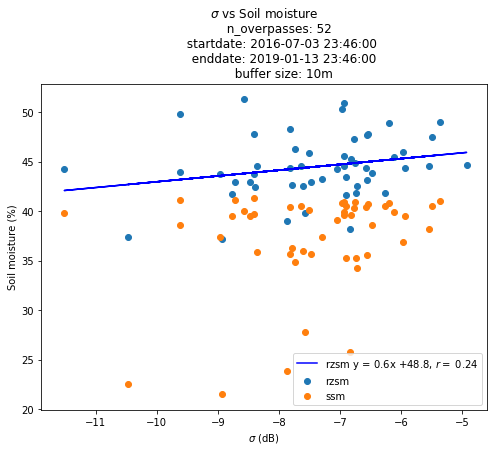

In [164]:
plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture 
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], "10"))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(mean_sigmas, rzsm, label = 'rzsm')
plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [ ]:
# as a timeseries

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''$\sigma$ vs Soil moisture Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel("$\sigma$ (dB)", color=color)
ax1.plot(dates, mean_sigmas, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# remove the days with high preceding rainfall 

In [ ]:
imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

In [ ]:
def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-1, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

In [ ]:
rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)

In [ ]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])

In [ ]:
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])

In [ ]:
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''2 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("Precip (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [ ]:
# Let's test with 4 day precip accumulation

imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-4, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)
    

In [ ]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''4 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("3 day precipitation (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation (4 days)
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()